# 잠재 요인 기반 추천시스템 ALS 모델 만들기

In [77]:
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType

from pyspark.ml.recommendation import ALS

from pyspark.ml.evaluation import RegressionEvaluator

In [78]:
MAX_MEMORY = '7g'

ss = SparkSession\
                .builder\
                .appName('ALS')\
                .config('spark.executor.memory', MAX_MEMORY)\
                .config('spark.driver.memory', MAX_MEMORY)\
                .getOrCreate()

ss

In [79]:
rating_df = ss.read.format('csv')\
            .option('header', 'true')\
            .option('inferSchema', 'true')\
            .load('data/ratings.csv')

movie_df = ss.read.format('csv')\
            .option('header', 'true')\
            .option('inferSchema', 'true')\
            .load('data/movies.csv')

rating_df, movie_df

(DataFrame[userId: int, movieId: int, rating: double, timestamp: int],
 DataFrame[movieId: int, title: string, genres: string])

In [80]:
rating_df.schema, rating_df.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)



(StructType(List(StructField(userId,IntegerType,true),StructField(movieId,IntegerType,true),StructField(rating,DoubleType,true),StructField(timestamp,IntegerType,true))),
 None)

In [81]:
rating_df.show(10)

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|    296|   5.0|1147880044|
|     1|    306|   3.5|1147868817|
|     1|    307|   5.0|1147868828|
|     1|    665|   5.0|1147878820|
|     1|    899|   3.5|1147868510|
|     1|   1088|   4.0|1147868495|
|     1|   1175|   3.5|1147868826|
|     1|   1217|   3.5|1147878326|
|     1|   1237|   5.0|1147868839|
|     1|   1250|   4.0|1147868414|
+------+-------+------+----------+
only showing top 10 rows



### 전처리
- timestamp는 생략

In [82]:
rating_df = rating_df.select('userID'
                            , 'movieID'
                            , 'rating')

### 데이터셋 분할

In [83]:
train_ratio = 0.8
test_ratio = 0.2

train_df, test_df = rating_df\
                            .randomSplit([train_ratio, test_ratio], seed = 42)

train_df, test_df

(DataFrame[userID: int, movieID: int, rating: double],
 DataFrame[userID: int, movieID: int, rating: double])

### ALS 모델 객체 생성

In [84]:
als = ALS(
        maxIter = 5, # 반복 횟수
        regParam = 0.1, # 정규화
        userCol = 'userID',
        itemCol = 'movieID',
        ratingCol = 'rating',
        #coldStartStrategy = 'drop' #나는 뒤에 옵션을 주고 훈련을 다시 시켰음
    )

als

ALS_a1e24edb8782

In [85]:
als_model = als.fit(train_df)

In [86]:
als_model

ALSModel: uid=ALS_a1e24edb8782, rank=10

### 예측 확인

In [87]:
#userID, movieID를 가지고 rating을 예측함
predictions = als_model.transform(test_df)
predictions.show()

+------+-------+------+----------+
|userID|movieID|rating|prediction|
+------+-------+------+----------+
| 26480|    148|   2.0|  2.015058|
| 28229|    148|   1.0| 2.4849591|
|  6491|    148|   4.0| 2.3561327|
| 14831|    148|   3.0| 2.7581735|
| 69123|    148|   4.5| 2.3344429|
|104825|    148|   4.0| 3.1337254|
| 41703|    148|   2.0| 2.8869498|
| 29213|    148|   5.0| 2.3444452|
| 75209|    148|   2.0|  2.591187|
|115912|    148|   3.0|  2.552612|
|118261|    148|   3.0| 3.0280576|
| 70733|    148|   1.0| 2.9115403|
|115095|    148|   4.0|  3.354445|
|  7223|    148|   3.0|  2.541622|
| 65981|    148|   3.5| 2.9935696|
| 74794|    148|   3.0| 2.4340513|
| 33145|    148|   5.0| 2.9931223|
|110166|    148|   4.5| 2.4152575|
| 28366|    148|   5.0|  3.551271|
| 74016|    148|   4.0|  2.621664|
+------+-------+------+----------+
only showing top 20 rows



In [88]:
predictions.select('rating', 'prediction').describe().show()

+-------+------------------+----------+
|summary|            rating|prediction|
+-------+------------------+----------+
|  count|           3867951|   3867951|
|   mean|3.5329156186311566|       NaN|
| stddev|1.0621491114905193|       NaN|
|    min|               0.5|-1.1905621|
|    max|               5.0|       NaN|
+-------+------------------+----------+



In [89]:
predictions.selectExpr('avg(prediction)').show()

+---------------+
|avg(prediction)|
+---------------+
|            NaN|
+---------------+



### ALS 모델의 하이퍼 파라미터 조정
coldStartStrategy('drop') : 예측에 충분하지 않은 컬럼의 데이터의 경우 drop  

학습한 모델의 속성을 변경 > 다시 예측을 한 경우에도 조정이 안됨 >> 다시 학습부터 실행해야함

빈 값에 대해서 추천을 해줘야하는데 추천할 데이터도 부족할때 어떻게 이를 처리할 것인지에 대한 전략

In [90]:
#setColdStartStrategy는 없는 값은 그냥 뺀다는 개념
als = als.setColdStartStrategy('drop')

In [91]:
als_model = als.fit(train_df)

In [92]:
#userID, movieID를 가지고 rating을 예측함
predictions = als_model.transform(test_df)
predictions.show()

+------+-------+------+----------+
|userID|movieID|rating|prediction|
+------+-------+------+----------+
| 26480|    148|   2.0|  2.015058|
| 28229|    148|   1.0| 2.4849591|
|  6491|    148|   4.0| 2.3561327|
| 14831|    148|   3.0| 2.7581735|
| 69123|    148|   4.5| 2.3344429|
|104825|    148|   4.0| 3.1337254|
| 41703|    148|   2.0| 2.8869498|
| 29213|    148|   5.0| 2.3444452|
| 75209|    148|   2.0|  2.591187|
|115912|    148|   3.0|  2.552612|
|118261|    148|   3.0| 3.0280576|
| 70733|    148|   1.0| 2.9115403|
|115095|    148|   4.0|  3.354445|
|  7223|    148|   3.0|  2.541622|
| 65981|    148|   3.5| 2.9935696|
| 74794|    148|   3.0| 2.4340513|
| 33145|    148|   5.0| 2.9931223|
|110166|    148|   4.5| 2.4152575|
| 28366|    148|   5.0|  3.551271|
| 74016|    148|   4.0|  2.621664|
+------+-------+------+----------+
only showing top 20 rows



In [93]:
predictions.select('rating', 'prediction').describe().show()

+-------+------------------+------------------+
|summary|            rating|        prediction|
+-------+------------------+------------------+
|  count|           3864920|           3864920|
|   mean|  3.53334493340095| 3.395829430988672|
| stddev|1.0620045316020874|0.6403800606200472|
|    min|               0.5|        -1.1905621|
|    max|               5.0|          6.849581|
+-------+------------------+------------------+



### 평가
RMSE 측정(평균제곱근 오차)

In [94]:
evaluator = RegressionEvaluator(metricName = 'rmse'
                                , labelCol = 'rating'
                                , predictionCol = 'prediction')

evaluator

RegressionEvaluator_7ad895e03f97

In [95]:
rmse = evaluator.evaluate(predictions)
rmse

0.8156650359516072

## 활용

1. 사용자ID > 추천목록
2. 영화ID > 사용자 목록

In [97]:
als_model.recommendForAllUsers(3).show() #모든 사용자를 위한 3개씩 추천 영화를 제공함

+------+--------------------+
|userID|     recommendations|
+------+--------------------+
|   148|[{151989, 6.23390...|
|   463|[{139036, 7.33161...|
|   471|[{127252, 6.04067...|
|   496|[{151989, 6.76371...|
|   833|[{185645, 5.64903...|
|  1088|[{139036, 6.85566...|
|  1238|[{203086, 6.71504...|
|  1342|[{120272, 6.07571...|
|  1580|[{185645, 6.44235...|
|  1591|[{127252, 8.17993...|
|  1645|[{185645, 6.02166...|
|  1829|[{177209, 6.19302...|
|  1959|[{177209, 6.86742...|
|  2122|[{134585, 5.55104...|
|  2142|[{127252, 6.68972...|
|  2366|[{151989, 5.88864...|
|  2659|[{203086, 6.77798...|
|  2866|[{151989, 6.34049...|
|  3175|[{177209, 5.90312...|
|  3749|[{194334, 5.73140...|
+------+--------------------+
only showing top 20 rows



In [98]:
als_model.recommendForAllItems(3).show() #모든 아이템를 위한 3개씩 추천 사용자를 제공함

+-------+--------------------+
|movieID|     recommendations|
+-------+--------------------+
|    148|[{59460, 4.015474...|
|    463|[{87426, 5.270176...|
|    471|[{66365, 4.931283...|
|    496|[{31506, 4.688202...|
|    833|[{87426, 5.617653...|
|   1088|[{26659, 5.274371...|
|   1238|[{3195, 5.122861}...|
|   1342|[{87426, 5.145222...|
|   1580|[{87426, 5.353981...|
|   1591|[{87426, 4.961000...|
|   1645|[{87426, 5.290515...|
|   1829|[{81548, 4.200044...|
|   1959|[{105801, 4.99234...|
|   2122|[{87426, 5.112242...|
|   2142|[{87426, 4.792186...|
|   2366|[{3195, 5.1873155...|
|   2659|[{19143, 4.51319}...|
|   2866|[{66365, 5.005367...|
|   3175|[{105130, 5.13958...|
|   3749|[{28479, 4.971270...|
+-------+--------------------+
only showing top 20 rows



In [65]:
user_list = [65, 78, 81]
user_recommend_movies = als_model.recommendForUserSubset(
                                    ss.createDataFrame(user_list, IntegerType())\
                                        .toDF('userID')\
                                    , 3
                                    )

user_recommend_movies.show(truncate = False)

+------+---------------------------------------------------------------+
|userID|recommendations                                                |
+------+---------------------------------------------------------------+
|65    |[{177209, 6.8393207}, {151989, 6.763807}, {120272, 6.6476264}] |
|78    |[{120272, 7.0371647}, {194434, 7.0371647}, {177209, 6.8445168}]|
|81    |[{203882, 4.7355533}, {168906, 4.597749}, {184971, 4.5918174}] |
+------+---------------------------------------------------------------+



In [62]:
movie_df.show(10)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
|      6|         Heat (1995)|Action|Crime|Thri...|
|      7|      Sabrina (1995)|      Comedy|Romance|
|      8| Tom and Huck (1995)|  Adventure|Children|
|      9| Sudden Death (1995)|              Action|
|     10|    GoldenEye (1995)|Action|Adventure|...|
+-------+--------------------+--------------------+
only showing top 10 rows



In [66]:
# 65번 사용자의 추천영화목록
movies_list = user_recommend_movies.collect()[0].recommendations
movies_list

[Row(movieID=177209, rating=6.839320659637451),
 Row(movieID=151989, rating=6.7638068199157715),
 Row(movieID=120272, rating=6.6476263999938965)]

In [67]:
rec_df = ss.createDataFrame(movies_list)
rec_df.show()

+-------+------------------+
|movieID|            rating|
+-------+------------------+
| 177209| 6.839320659637451|
| 151989|6.7638068199157715|
| 120272|6.6476263999938965|
+-------+------------------+



In [75]:
# 영화 정보와 추천영화 목록을 조인
rec_df.createOrReplaceTempView('recommend')
movie_df.createOrReplaceTempView('movies')

ss.sql('''
    SELECT
        A.movieID
        , A.movieID = B.movieID as `검증(ID가 같은지)`
        , B.title
        , B.genres
        , A.rating
    
    FROM recommend as A
    INNER JOIN movies as B
    on A.movieID = B.movieID
''')\
.show()

+-------+-----------------+----------------+------+------------------+
|movieID|검증(ID가 같은지)|           title|genres|            rating|
+-------+-----------------+----------------+------+------------------+
| 177209|             true|  Acı Aşk (2009)| Drama| 6.839320659637451|
| 151989|             true|The Thorn (1971)|Comedy|6.7638068199157715|
| 120272|             true|Get Crazy (1983)|Comedy|6.6476263999938965|
+-------+-----------------+----------------+------+------------------+



In [99]:
ss.stop()

### spark 세팅값 참조
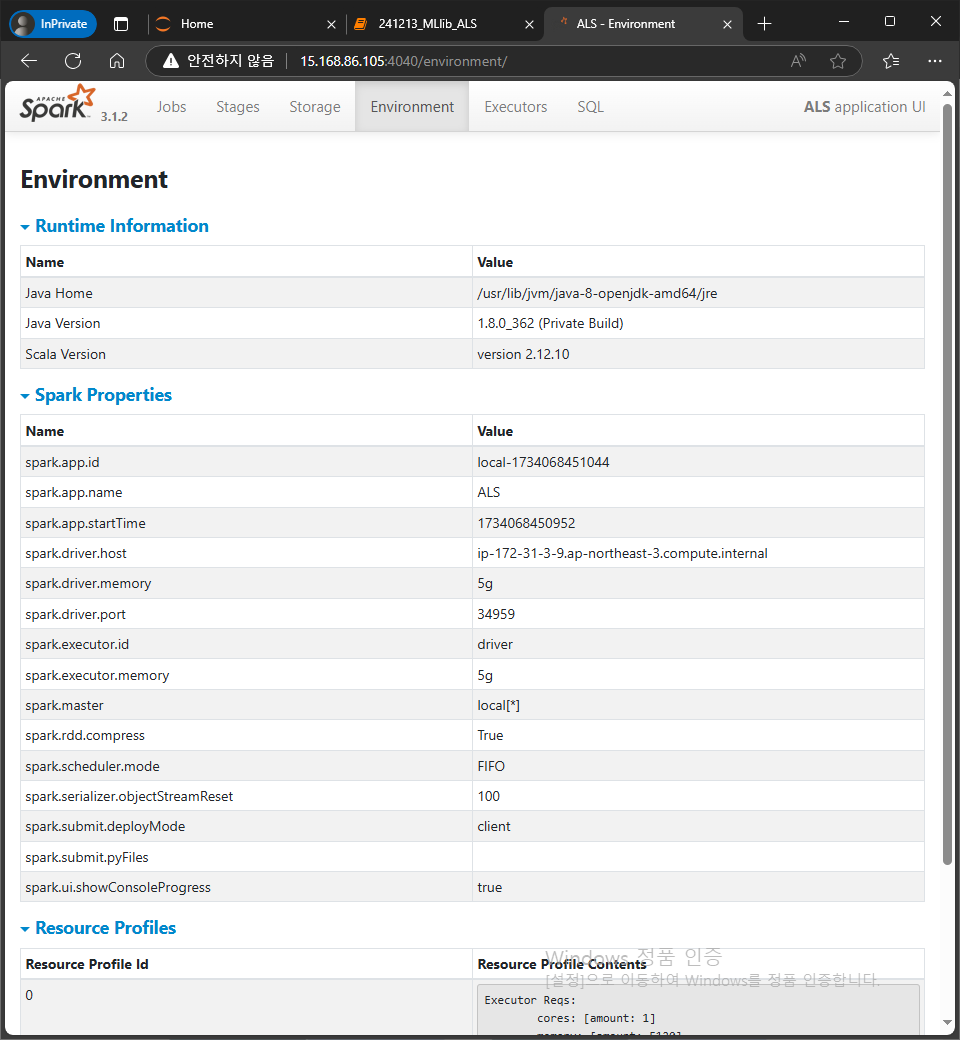
